# Data Cleaning and Exploratory Data Analysis

### Problem Statement:

Reddit is a popular social media platform that allows users to post content that other users can interact with by providing feedback and reactions in the form of comments. Some of the content shared within Reddit is more popular than the rest based on the number of comments it receives. 

[Foundation](https://foundationinc.co/lab/reddit-research/), a content marketing firm, states in a report that Reddit has over 300 million monthly active users, serving as a fertile ground for promoting content in the form of threads and advertisements. From a marketing perspective, it is important to understand what characteristics of a Reddit post can serve as distinguishing factors based on the number of interactions a post generates as measured by the number of comments it receives.

This research project will determine **what characteristics of a post on Reddit are most predictive of the overall interaction on a thread as measured by the number of comments**. Identifying these characteristics will allow product marketers, social media influencers, and other stakeholders customize Reddit posts to maximize the amount of interaction generated by their content in this platform. In particular, it is expected that more visibility of content will result in higher brand-awareness and greater revenue opportunities for a variety of companies wanting to promote their products or information on Reddit.

In particular, the Chief Content Officer at FiveThirtyEight is the primary audience for this project. By analyzing over 10,000 posts collected from the [Reddit](https://www.reddit.com/) webpage of most popular threads, a natural language processing model will be developed to identify which characteristics and posts of a Reddit post are most predictive of high interaction with a post. This information will be used by FiveThirtyEight's marketing team in customizing threads and content on this platform to maximize the level of engagement with the content. A higher level of engagement is expected to result in greater use of FiveThirtyEight's content and greater monetary opportunities through advertisement contracts.

The text data from Reddit posts will be vectorized using several methods such as [term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and used to predict whether a post contains a number of posts that is above the median number of posts. Additional derived features from the posts will be used in the prediction. A random forest, K-nearest neighbor, and decision tree classification models will be used to evaluate the accuracy of the predicted classification. The best model selected will be the one that will produce the highest accuracy, recall, and precision scores. All models' results will be compared to the null model or the percentage of posts with a number of comments above the median. 

### Data Cleaning and EDA:

#### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.preprocessing import StandardScaler

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from spacymoji import Emoji

# Data Cleaning and Exploratory Data Analysis

#### Ingest the scrapped data.

In [2]:
df = pd.read_csv('https://reddit-posts-webscraping.s3.amazonaws.com/web_scrapping_results.csv')

In [3]:
df.head()

,title,time,subreddit,number_comments,image,video,date_scrapped
0,Twitter permanently suspends Marjorie Taylor G...,5 hours ago,r/news,4.7k comments,0.0,0.0,2022-01-02 15:24:48
1,"Ontario Jan 02: 16,714 Cases, 16 Deaths 🏥 ICUs...",5 hours ago,r/ontario,605 comments,0.0,0.0,2022-01-02 15:24:48
2,What short sentence does every man want to hear?,4 hours ago,r/AskReddit,2.7k comments,0.0,0.0,2022-01-02 15:24:48
3,Landlord wants to raise my rent.,5 hours ago,r/PersonalFinanceCanada,314 comments,0.0,0.0,2022-01-02 15:24:48
4,The armor of a French soldier wounded by a can...,4 hours ago,r/interestingasfuck,1.9k comments,0.0,0.0,2022-01-02 15:24:48


#### Check for missing data.
The data was collected making sure that all required features are available for this analysis.

In [4]:
df.isnull().sum().sum()

0

#### Check the data types.
All features, except the binary `image` and `video` features, are object type as expected.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18769 entries, 0 to 18768
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            18769 non-null  object 
 1   time             18769 non-null  object 
 2   subreddit        18769 non-null  object 
 3   number_comments  18769 non-null  object 
 4   image            18769 non-null  float64
 5   video            18769 non-null  float64
 6   date_scrapped    18769 non-null  object 
dtypes: float64(2), object(5)
memory usage: 1.0+ MB


The data may contain posts that are duplicated as a result of posts having been collected in more than one round of web-scrapping. Remove these duplications by keeping only the latest scrapped post.

In [6]:
df['latest_scrapped_date'] = df['date_scrapped'].groupby(df['title']).transform(max)

# This resource was helpful in producing the latest_date_scrapped feature
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html

In [7]:
df.sort_values(['title','date_scrapped']).head()

,title,time,subreddit,number_comments,image,video,date_scrapped,latest_scrapped_date
18413,"""1 day on this planet is 10 years on earth,"" s...",12 hours ago,r/TwoSentenceHorror,96 comments,0.0,0.0,2021-12-23 02:14:08,2021-12-23 02:14:08
13596,"""And you're gonna hear me ROAR!""",9 hours ago,r/dankmemes,121 comments,1.0,0.0,2021-12-24 23:40:19,2021-12-24 23:40:19
6925,"""Be my Boudicca""",8 hours ago,r/suspiciouslyspecific,266 comments,1.0,0.0,2021-12-28 15:53:59,2021-12-28 17:33:07
6246,"""Be my Boudicca""",9 hours ago,r/suspiciouslyspecific,314 comments,1.0,0.0,2021-12-28 17:33:07,2021-12-28 17:33:07
5495,"""Calling people chasers is akin to calling the...",4 hours ago,r/asktransgender,105 comments,0.0,0.0,2021-12-29 12:40:36,2021-12-29 12:40:36


In [8]:
df = df[df['date_scrapped'] == df['latest_scrapped_date']]

In [9]:
df.reset_index(drop=True,inplace=True)

In [10]:
df.shape

(10106, 8)

Clean the object-type data to a numerical form for use in this analysis.
* Convert the number of hours since the thread was posted to numerical format
    * From this numerical variable, estimate the time when the reddit was posted
* Convert the number of comments in the post to numerical format

#### Calculate a feature to represent the amount of time elapsed since the thread was posted in hours.

In [11]:
df['time_num'] = [float(value.split()[0]) for value in df.time]

In [12]:
df['time_scale'] = [value.split()[1] for value in df.time]

In [13]:
df['time_scale'].value_counts()

hours      10036
hour          43
day           14
minutes       12
month          1
Name: time_scale, dtype: int64

In [14]:
df['time_num'] = np.where(df.time_scale.str.contains('minute'),df['time_num'] * (1/60),df['time_num'])

In [15]:
df['time_num'] = np.where(df.time_scale.str.contains('day'),df['time_num'] * 24,df['time_num'])

In [16]:
df['time_num'] = np.where(df.time_scale.str.contains('month'),df['time_num'] * 720,df['time_num'])

Now that the number of hours since the post was added is expressed as a numerical value, estimate the time of posting using the `datetime` function.

These resources were useful in the calculation of the date posted below: ([1](https://www.mytecbits.com/internet/python/addition-and-subtraction-of-time) + [2](https://stackoverflow.com/questions/47351334/python-joint-enumerate-with-multiple-variables))

In [17]:
for i,(date,time) in enumerate(zip(df.date_scrapped,df.time_num)):
    df.loc[i,'date_posted'] = datetime(year=int(date.split()[0].split('-')[0]),
        month=int(date.split()[0].split('-')[1]),
        day=int(date.split()[0].split('-')[2]),
        hour=int(date.split()[1].split(':')[0]),
        minute=int(date.split()[1].split(':')[1]),
        second=int(date.split()[1].split(':')[2])) - timedelta(hours=time)

From the date posted, the date and hour of posting are included in the data frame to evaluate if there is a relationship between the number of comments and date and hour of posting.

In [18]:
df['date_posting'] = [str(value).split()[0] for value in df['date_posted']]

In [19]:
df['hour of posting'] = [int(str(value).split()[1].split(':')[0]) for value in df['date_posted']]

In [20]:
df.head(2)

,title,time,subreddit,number_comments,image,video,date_scrapped,latest_scrapped_date,time_num,time_scale,date_posted,date_posting,hour of posting
0,Twitter permanently suspends Marjorie Taylor G...,5 hours ago,r/news,4.7k comments,0.0,0.0,2022-01-02 15:24:48,2022-01-02 15:24:48,5.0,hours,2022-01-02 10:24:48,2022-01-02,10
1,"Ontario Jan 02: 16,714 Cases, 16 Deaths 🏥 ICUs...",5 hours ago,r/ontario,605 comments,0.0,0.0,2022-01-02 15:24:48,2022-01-02 15:24:48,5.0,hours,2022-01-02 10:24:48,2022-01-02,10


The outcome variable of the analysis will require converting the data from its current text form to numerical form.

#### Convert number of comments feature to a numerical variable.

In [21]:
df['num_comments'] = [num.replace(" comments", "") for num in df.number_comments]

In [22]:
df['num_comments'] = [num.replace(" comment", "") for num in df.num_comments]

The scale of the number of comments will be obtained below for proper scaling of the number of comments.

In [23]:
df['scale'] = [[digit if digit.isalpha() else '1' for digit in char] for char in df.num_comments]
# This resource was useful in using the .isalpha() method:
# https://www.w3schools.com/python/ref_string_isalpha.asp

In [24]:
df['scale'] = [value[-1] for value in df.scale]

In [25]:
df['scale'] = df['scale'].replace('k','1000').astype('int')

In [26]:
df['num_comments'] = [float(num.replace("k", "")) for num in df.num_comments]

In [27]:
df['num_comments'] = df['num_comments'] * df['scale']

In [28]:
df.scale.value_counts()

1       9014
1000    1092
Name: scale, dtype: int64

In [29]:
df.head(2)

,title,time,subreddit,number_comments,image,video,date_scrapped,latest_scrapped_date,time_num,time_scale,date_posted,date_posting,hour of posting,num_comments,scale
0,Twitter permanently suspends Marjorie Taylor G...,5 hours ago,r/news,4.7k comments,0.0,0.0,2022-01-02 15:24:48,2022-01-02 15:24:48,5.0,hours,2022-01-02 10:24:48,2022-01-02,10,4700.0,1000
1,"Ontario Jan 02: 16,714 Cases, 16 Deaths 🏥 ICUs...",5 hours ago,r/ontario,605 comments,0.0,0.0,2022-01-02 15:24:48,2022-01-02 15:24:48,5.0,hours,2022-01-02 10:24:48,2022-01-02,10,605.0,1


#### Calculate a feature for whether the number of comments is below or above the median.


In [30]:
df['high_num_comments'] = df['num_comments'].apply(lambda x: 1 if x > np.median(df['num_comments']) else 0)

In [31]:
np.median(df['num_comments'])

176.0

The median number of comments is 176. As can be seen below, the data is almost evenly split among the percentage of posts that have and do not have a number of comments above the median.

In [32]:
df.high_num_comments.value_counts(normalize=True)

0    0.501385
1    0.498615
Name: high_num_comments, dtype: float64

Drop columns that will not be used in the analysis.

In [33]:
df = df.drop(columns=['number_comments','time','date_scrapped','latest_scrapped_date','time_scale','date_posted','scale'])

In [34]:
df.head()

,title,subreddit,image,video,time_num,date_posting,hour of posting,num_comments,high_num_comments
0,Twitter permanently suspends Marjorie Taylor G...,r/news,0.0,0.0,5.0,2022-01-02,10,4700.0,1
1,"Ontario Jan 02: 16,714 Cases, 16 Deaths 🏥 ICUs...",r/ontario,0.0,0.0,5.0,2022-01-02,10,605.0,1
2,What short sentence does every man want to hear?,r/AskReddit,0.0,0.0,4.0,2022-01-02,11,2700.0,1
3,Landlord wants to raise my rent.,r/PersonalFinanceCanada,0.0,0.0,5.0,2022-01-02,10,314.0,1
4,The armor of a French soldier wounded by a can...,r/interestingasfuck,0.0,0.0,4.0,2022-01-02,11,1900.0,1


To understand the characteristics of posts that have a high number of comments the following approach will be used:
* The Reddit posts with most comments will be visually analyzed for common patterns
* A report on [Reddit research](https://foundationinc.co/lab/reddit-research/) by `Foundation` will be used as background information
* Derived features will be calculated from the text data to explore characteristics of the posts and their relationship to the number of comments

#### First, examine the distribution of the numerical features
The distribution of the number of comments is skewed to the right with most posts having less than 1000 comments. A few posts have a very high number of comments. The characteristics of these posts are explored next.

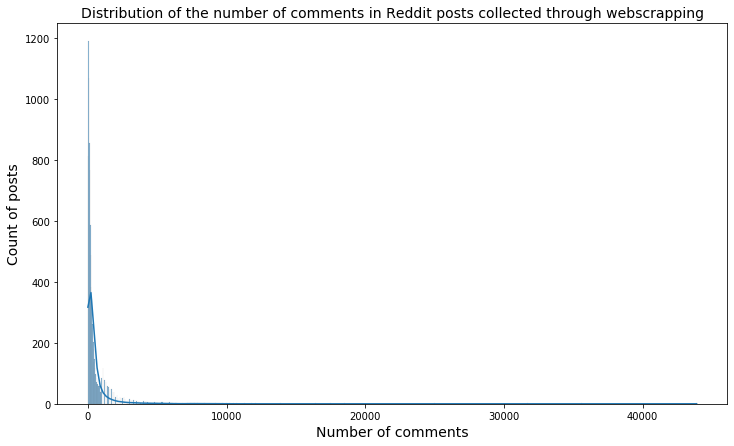

In [35]:
plt.figure(figsize=(12,7))
plt.xlabel('Number of comments', size=14)
plt.ylabel('Count of posts', size=14)
plt.title('Distribution of the number of comments in Reddit posts collected through webscrapping', size=14)
sns.histplot(data=df,x='num_comments', kde=True);

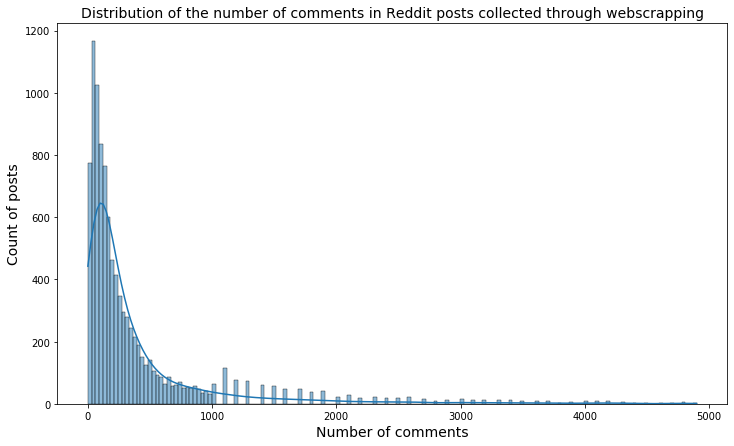

In [36]:
plt.figure(figsize=(12,7))
plt.xlabel('Number of comments', size=14)
plt.ylabel('Count of posts', size=14)
plt.title('Distribution of the number of comments in Reddit posts collected through webscrapping', size=14)
sns.histplot(data=df[df['num_comments']<5000],x='num_comments', kde=True);

In [37]:
list(df[df['num_comments']>5000].sort_values('num_comments',ascending=False).head(10)['title'])

['[Game Thread] Orange Bowl Semifinal - Michigan vs. Georgia (7:30PM ET)',
 'What ruins a movie instantly?',
 'Whats criminally overpriced to you?',
 'What tastes good hot and cold?',
 'What is something americans will never understand ?',
 'Non picky eaters, what’s a food you just cannot do?',
 'What’s a controversial music opinion that you have?',
 'Which TV show has never had a bad episode?',
 "GIVEAWAY: I'm giving away Escape From Tarkov: Prepare for Escape Edition or $100 Cash to one comment in this thread",
 'If you were handed 10 billion dollars right now, what would you still never buy?']

In [38]:
list(df[(df['num_comments']<5000) & (df['num_comments']>176)].sort_values('num_comments',ascending=False).head(10)['title'])

['Florida breaks single-day COVID case record',
 'What’s their indie folk band called?',
 'This donut shop also sells guns',
 '“All I need to cook is a set of measuring cups and spoons, American style.”',
 '| $GME Daily Discussion | New to the sub? Start here!',
 'What should be free?',
 'What Are Your Moves Tomorrow, December 27, 2021',
 "What's an obvious lie you think we all accept to make eachother feel good?",
 'What the fuck type of sport is this?',
 'MONDAY NIGHT GAME THREAD - WEEK 16']

The lists below display the posts with the highest number of comments in the ranges above 5000 comments and between 176 to 5000 comments or above the median number of comments.

From these lists, it is clear that:
* Posts that receive several comments in most cases are framed as questions. This is supported by Foundation's research on Reddit.
* Posts that contain a reference to money such as `$`, `billion`, or `dollars` tend to have a higher number of comments
* Words that reflect current and wide-spread events such as `COVID` appear to also have a higher number of comments
* The use of `vs.` may elicit more comments as it is drawing attention to a particular object of competition or dispute, of which many reddit users may have opinions about.

Generate a variable for whether the title includes a reference to a question.

In [39]:
question_in_title = []
question_words = ['What','Which','Who','Where','Why','When','Whose', 'how']
for title in df.title:
    count = 0
    for question_word in question_words:
        if (question_word.lower() in title.lower() and '?' in title.lower()):
            count += 1
    question_in_title.append(count)

In [40]:
df['question_in_title'] = question_in_title

In [41]:
df['question_in_title'].value_counts(normalize=True)

0    0.916980
1    0.074411
2    0.008213
3    0.000396
Name: question_in_title, dtype: float64

In [42]:
df.groupby('question_in_title').mean()['num_comments']

question_in_title
0     436.834251
1    1474.843085
2    1461.277108
3     384.000000
Name: num_comments, dtype: float64

In [43]:
df['question_in_title'] = df['question_in_title'].apply(lambda x: 1 if x > 0 else 0)

Posts framed as questions appear to draw a high number of comments.

In [44]:
df[df['question_in_title']==1].head()

,title,subreddit,image,video,time_num,date_posting,hour of posting,num_comments,high_num_comments,question_in_title
2,What short sentence does every man want to hear?,r/AskReddit,0.0,0.0,4.0,2022-01-02,11,2700.0,1,1
6,What's something that everyone in the world ca...,r/AskReddit,0.0,0.0,9.0,2022-01-01,19,9900.0,1,1
8,What is a survival myth that is completely wro...,r/AskReddit,0.0,0.0,3.0,2022-01-02,1,1800.0,1,1
9,What should be free?,r/AskReddit,0.0,0.0,7.0,2022-01-01,21,4800.0,1,1
12,What TV series is full of quotable lines?,r/AskReddit,0.0,0.0,17.0,2022-01-01,10,20100.0,1,1


On average, posts that are framed as questions have a higher average number of comments although among posts that framed as a question and not as a question, the average number of comments in both is above the median.

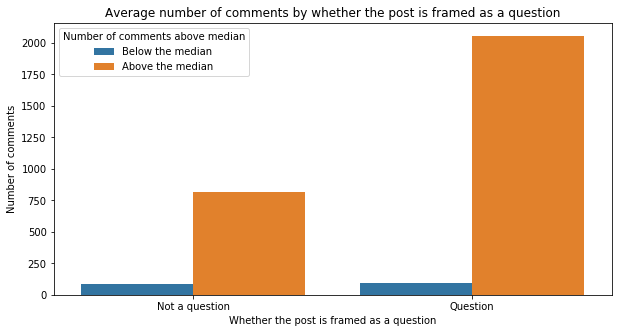

In [45]:
plt.figure(figsize=(10,5))
plot = sns.barplot(data=df,x='question_in_title', y='num_comments',ci= None, hue='high_num_comments')
plt.ylabel('Number of comments')
plt.xlabel('Whether the post is framed as a question')
plot.set_xticklabels(['Not a question','Question'])
plt.title('Average number of comments by whether the post is framed as a question')
plot.legend(title='Number of comments above median', loc='upper left', labels=['Below the median','Above the median']);

# This resource was helpful in assigning labels to the legend:
# https://stackoverflow.com/questions/45201514/how-to-edit-a-seaborn-legend-title-and-labels-for-figure-level-functions

Some posts are not posed as a question and also have high number of comments.
* Contain dollar sign
* Contain the acronym for `versus`
* Reflect news content

In [46]:
list(df[df['question_in_title']==0].sort_values('num_comments',ascending=False)['title'].head(30))

['[Game Thread] Orange Bowl Semifinal - Michigan vs. Georgia (7:30PM ET)',
 "GIVEAWAY: I'm giving away Escape From Tarkov: Prepare for Escape Edition or $100 Cash to one comment in this thread",
 "GIVEAWAY: I'm giving away $100 worth of The Witcher merch to one comment in this thread",
 'For me its Agent 47, so ofc I am fucked',
 'Giveaway: 100$ Playstation Store Gift Card to one lucky commentor within 24 hours from this post.',
 'FREE SILVER GIVEAWAY on REDDIT ... 15oz of SILVER FREE !!! Just comment why you love Silver and upvote this post. We will select 6 winners. 1st place gets 10oz End The Fed bar, 5 runner-up winners will get 1 oz WSS round! Contest ends New Years Eve at Midnight eastern time! 🚀',
 "GIVEAWAY: I'm giving away a $100 Blizzard Balance Gift Card to one comment in this thread",
 "A kid gets trampled by The Queen's Guard",
 '[CHRISTMAS GIVEAWAY] Hello PCMasterRace! In christmas spirit we’re giving away 5 desk mats of your choice! Choose from our collection of custom a

Create a variable for whether the dollar sign is included in the thread title.

In [47]:
dollar_sign = []
money = ['money','$','dollar','cents','cash','gift card','coupon','giveaway','euro','bonds','stocks','equity','debt']
for title in df.title:
    count = 0
    for value in money:
        if value in title.lower():
            count += 1
    dollar_sign.append(count)

In [48]:
df['dollar_sign'] = dollar_sign

In [49]:
df['dollar_sign'] = df['dollar_sign'].apply(lambda x: 1 if x > 0 else 0)

In [50]:
df['dollar_sign'].value_counts()

0    9874
1     232
Name: dollar_sign, dtype: int64

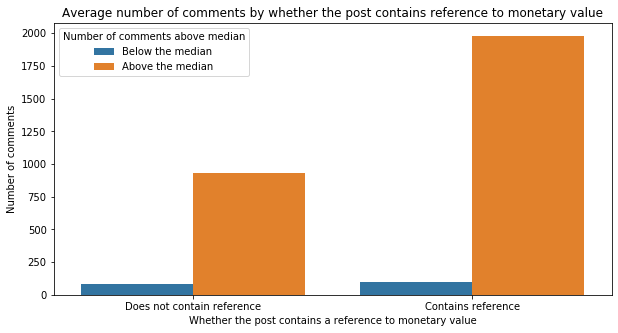

In [51]:
plt.figure(figsize=(10,5))
plot = sns.barplot(data=df,x='dollar_sign', y='num_comments',ci= None, hue='high_num_comments')
plt.ylabel('Number of comments')
plt.xlabel('Whether the post contains a reference to monetary value')
plot.set_xticklabels(['Does not contain reference','Contains reference'])
plt.title('Average number of comments by whether the post contains reference to monetary value')
plot.legend(title='Number of comments above median', loc='upper left', labels=['Below the median','Above the median']);

In [52]:
competition = []
competition_words = ['nfl','nba','mlb','nhl','mls','soccer','basketball','semi-final','quarter-final','quarterback',
                    'football','vs','ncaa','manchester united','lakers'] 
for title in df.title:
    count = 0
    for word in competition_words:
        if word in title.lower():
            count +=1
    competition.append(count)

df['competition_key_word'] = competition

In [53]:
df['competition_key_word'].value_counts()

0    9879
1     219
2       8
Name: competition_key_word, dtype: int64

In [54]:
df['competition_key_word'] = df['competition_key_word'].apply(lambda x: 1 if x > 0 else 0)

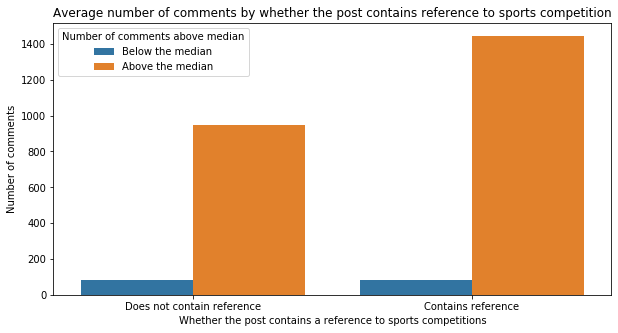

In [55]:
plt.figure(figsize=(10,5))
plot = sns.barplot(data=df,x='competition_key_word', y='num_comments',ci= None, hue='high_num_comments')
plt.ylabel('Number of comments')
plt.xlabel('Whether the post contains a reference to sports competitions')
plot.set_xticklabels(['Does not contain reference','Contains reference'])
plt.title('Average number of comments by whether the post contains reference to sports competition')
plot.legend(title='Number of comments above median', loc='upper left', labels=['Below the median','Above the median']);

There does not appear to be a completely clear relationship between the binary features of whether a post is posed as a question and contains a reference to a monetary value and or whether the post contains a reference to spots and competitions because in both the positive and negative classes, the average number of posts is above the median for each of these features. However, the feature for the post being posed as a question and whether the post contains a reference to monetary value will be maintained in the analysis as the difference in the average number of comments among both classes is significant among posts with a median number of comments above the median. Although this appears to be less true for references to sports and competitions, this feature will be kept in the analysis as it may reveal a topic preference of reddit users for sports and competition related content.

#### Introduce a measure of polarity and subjectivity from each post.

In [56]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
# The polarity and subjectivity measures used here were inspired from the lesson notes on NLP:
# https://git.generalassemb.ly/dsi-andromeda/nlp-i/blob/master/starter-code-Sophie.ipynb

In [57]:
df['title_polarity'] = [nlp(value)._.polarity for value in df.title]

In [58]:
df['title_subjectivity'] = [nlp(value)._.subjectivity for value in df.title]

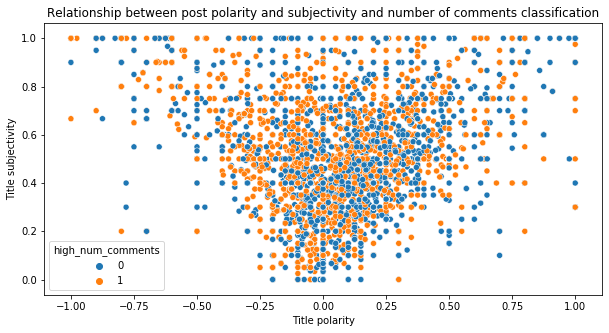

In [59]:
plt.figure(figsize=(10,5))
plt.title('Relationship between post polarity and subjectivity and number of comments classification')
plt.ylabel('Title subjectivity')
plt.xlabel('Title polarity')
plot = sns.scatterplot(data=df,x='title_polarity',y='title_subjectivity',hue='high_num_comments');

In [60]:
df[df['title_polarity']<0][['title_polarity','title_subjectivity','num_comments']].corr()

,title_polarity,title_subjectivity,num_comments
title_polarity,1.00000,-0.608700,-0.020590
title_subjectivity,-0.60870,1.000000,-0.014924
num_comments,-0.02059,-0.014924,1.000000


In [61]:
df[df['title_polarity']>0][['title_polarity','title_subjectivity','num_comments']].corr()

,title_polarity,title_subjectivity,num_comments
title_polarity,1.000000,0.450070,-0.026177
title_subjectivity,0.450070,1.000000,0.009991
num_comments,-0.026177,0.009991,1.000000


In [62]:
df[(df['title_polarity'] > .75) | (df['title_polarity'] < -.75)]['num_comments'].mean()

399.8762214983713

In [63]:
df[(df['title_polarity'] < .75) & (df['title_polarity'] > -.75)]['num_comments'].mean()

525.9086065573771

On average, it appears that that there is a moderate relationship between polarity and subjectivity in the data such that as the polarity is lower or there is an intrinsic negativity in the post, the subjectivity of the post increases. Overall, it appears that less posts are classified as having a median above the mean in the left region of the previous scatterplot, indicating that posts with a negative tone may be less likely to have a number of comments above the median. Overall, it appears that as the polarity increases, in the right region of the scatterplot, the subjectivity also increases and there is a higher number of posts classified as having a number of comments above the median.

However, it appears that the bulk of observations classified as having a number of comments above the median is around 0, or around the more neutral tones in posts. Therefore, redditors may be more interested in posts that add informative value and less extreme positive or negative opinions. These features will be kept in the analysis to explore these correlations further.

#### Introduce a measure for the number of emojis included in a thread
[This](https://spacy.io/universe/project/spacymoji) documentation was helpful in dealing with emojis.

In [64]:
nlp = spacy.load('en_core_web_sm')
emoji = Emoji(nlp)
nlp.add_pipe('emoji', first=True)

In [65]:
df['num_emojis'] = [len(nlp(doc)._.emoji) for doc in df.title]

In [66]:
df['num_emojis'].value_counts()

0     9726
1      240
2       75
3       40
4       16
7        3
6        3
5        1
45       1
11       1
Name: num_emojis, dtype: int64

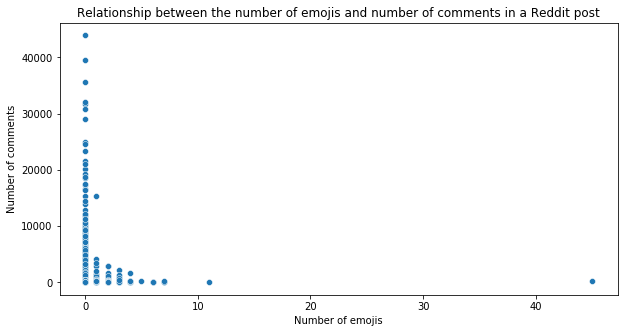

In [67]:
plt.figure(figsize=(10,5))
plt.title('Relationship between the number of emojis and number of comments in a Reddit post')
plt.ylabel('Number of comments')
plt.xlabel('Number of emojis')
sns.scatterplot(data=df,x='num_emojis',y='num_comments');

Overall, there does not appear to be any relationship between the number of emojis and comments.

If a thread contains a link to an external website or content source, the number of comments may be higher, as there is additional information to comment about. However, a very low number of posts include text in the post that includes the strings `.com`, `.net`, and `.org`, which represent external websites. Therefore, this feature will not be used in the analysis.

In [68]:
counter = []
domains = ['.com','.net','.org','www','website','https','blog','new york times','cnn','bbc','twitter','facebook']
for title in df.title:
    count = 0
    for domain in domains:
        if domain in title:
            count += 1
    counter.append(count)

#### Explore the relationship between the day of posting and hour of posting with the number of comments

Overall, the number of posts was higher around holidays such as new years eve. Capture this effect in a binary variable.

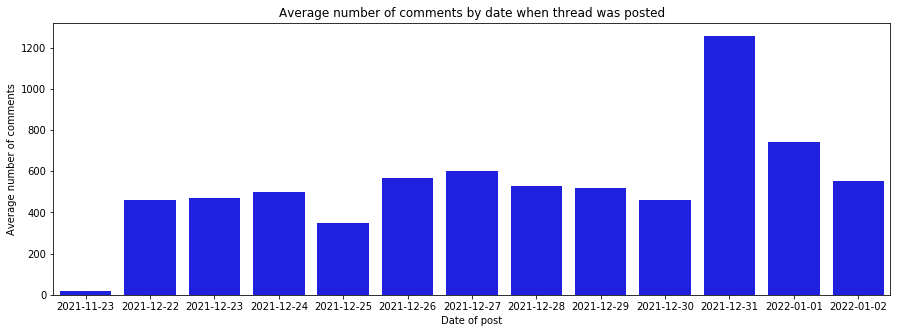

In [69]:
plt.figure(figsize=(15,5))
sns.barplot(data=df.sort_values('date_posting',ascending=True), x='date_posting',y='num_comments', ci=None,color='blue')
plt.title('Average number of comments by date when thread was posted')
plt.xlabel('Date of post')
plt.ylabel('Average number of comments');

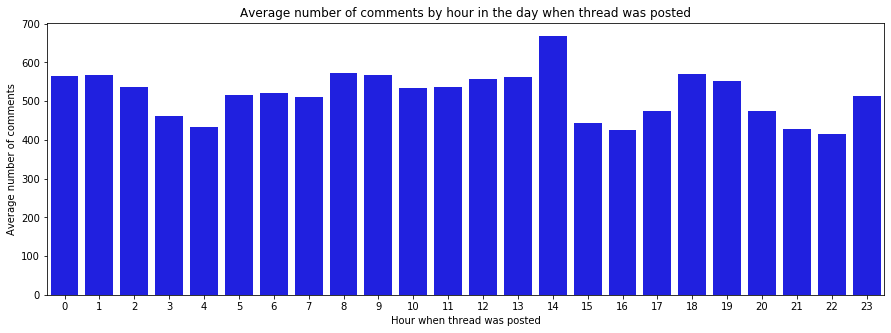

In [70]:
plt.figure(figsize=(15,5))
sns.barplot(data=df, x='hour of posting',y='num_comments', ci=None, color='blue')
plt.title('Average number of comments by hour in the day when thread was posted')
plt.xlabel('Hour when thread was posted')
plt.ylabel('Average number of comments');

In [71]:
df['holiday'] = df['date_posting'].apply(lambda x: 1 if x == '2021-12-30' or x == '2021-12-31' or x == '2022-01-01' else 0)

In [72]:
df['holiday'].value_counts()

0    8178
1    1928
Name: holiday, dtype: int64

In [73]:
df['hour_posted'] = df['hour of posting'].apply(lambda x: 1 if x >= 12 and x <= 14 else 0)

In [74]:
df['hour_posted'].value_counts()

0    8390
1    1716
Name: hour_posted, dtype: int64

#### Generate additional features from the posts including:
* Number of words per post
* Number of characters per post
* Number of punctuation signs
* Percentage of characters that are upper case
* Subreddit length
* Percentage of upper case characters in subreddit
* Number of posts per sureddit

#### Find the number of characters per post
A higher number of characters may be associated with more content and thus more engagement material for readers.

In [75]:
df['title_len'] = [len(post) for post in df.title]

#### Find the number of words per post
Similarly as in the number of characters, a higher number of words may be associated with more content for viewers, which may allow for more interaction with this content.

In [76]:
df['title_num_words'] = [len(post.split()) for post in df.title]

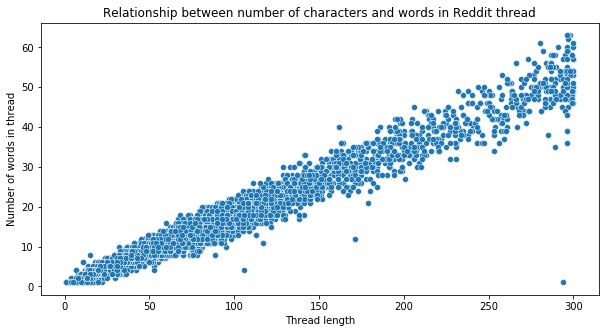

In [77]:
plt.figure(figsize=(10,5))
plt.title('Relationship between number of characters and words in Reddit thread')
plt.xlabel('Thread length')
plt.ylabel('Number of words in thread')
sns.scatterplot(df['title_len'],df['title_num_words']);

There is a very strong linear relationship between these two features suggesting that only one is necessary as an explanatory variable of the target. Choose `title_len` as it has a slightly higher correlation with the number of comments.

In [78]:
df[['title_len','title_num_words','num_comments']].corr()[['num_comments']]

,num_comments
title_len,0.027854
title_num_words,0.027515
num_comments,1.000000


In [79]:
df.drop(columns='title_num_words',inplace=True)

#### Find the number of punctuation signs per thread
A post that uses more punctuation signs may be more 'catchy' than a post without any punctuation signs.

In [80]:
punc = ['.','?',"”","“",'‘',',','-','–','!',':',';','(',')','[',']','…','/',"|"]

In [81]:
punc_count = []
for title in df.title:
    counter = 0
    for punc_mark in punc:
        if punc_mark in title:
            counter +=1
    punc_count.append(counter)

In [82]:
df['punc_count'] = punc_count

#### Find the number and percentage of upper case characters in each thread.
Similarly as above, posts with more upper case characters may signal more emotion and generate more comments from readers.

In [83]:
upper_count = []
for title in df.title:
    counter = 0
    for char in title:
        if char == str.upper(char) and char != ' ' and char not in punc:
            counter +=1
    upper_count.append(counter)

In [84]:
df['upper_count'] = upper_count

In [85]:
df['upper_case_pct'] = 100 * df['upper_count'] / df['title_len']

#### Find the number of characters in the subreddit
Lengthier subreddits might be distracting and less interesting to readers.

In [86]:
df['subreddit_text'] = [subreddit.split('/')[1] for subreddit in df.subreddit]

In [87]:
df['subreddit_len'] = [len(subreddit) for subreddit in df.subreddit_text]

#### Find the percentage of characters that are upper case in the subreddit
Subreddits that have more upper case characters may be catchier than subreddits without any upper case characters.

In [88]:
sub_upper_count = []
for subreddit in df.subreddit_text:
    counter = 0
    for char in subreddit:
        if char == str.upper(char) and char != ' ' and char not in punc:
            counter +=1
    sub_upper_count.append(counter)

In [89]:
df['sub_upper_count'] = sub_upper_count

In [90]:
df['sub_upper_case_pct'] = 100 * df['sub_upper_count'] / df['subreddit_len']

In [91]:
df.head(2)

,title,subreddit,image,video,time_num,date_posting,hour of posting,num_comments,high_num_comments,question_in_title,...,holiday,hour_posted,title_len,punc_count,upper_count,upper_case_pct,subreddit_text,subreddit_len,sub_upper_count,sub_upper_case_pct
0,Twitter permanently suspends Marjorie Taylor G...,r/news,0.0,0.0,5.0,2022-01-02,10,4700.0,1,0,...,0,0,70,0,5,7.142857,news,4,0,0.0
1,"Ontario Jan 02: 16,714 Cases, 16 Deaths 🏥 ICUs...",r/ontario,0.0,0.0,5.0,2022-01-02,10,605.0,1,0,...,0,0,163,7,47,28.834356,ontario,7,0,0.0


#### Find the number of posts per subreddit
Subreddits with a high number of posts may be popular among the Reddit community and may attract more engagement. This feature reflects the frequency of posting of each subreddit.

In [92]:
df['subreddit_cnt'] = [len(df[df['subreddit'] == subreddit]) for subreddit in df.subreddit]

#### Produce descriptive statistics of all numerical features in the data set.

Based on the binary features created earlier, the following can be inferred from the data:
* Images are a more common than videos in threads
* About half of posts have a number of comments above the median
* About six percent of titles are posted as a question
* Less than one percent of posts include a website link on the title
* Less than two percent of posts include a dollar sign on the thread
* Less than five percent of posts include a reference to names of politicians who ran for the 2020 presidential election in the U.S.
* Less than two percent of posts have a reference to current people events as defined in this analysis

In [93]:
df[['image','video','high_num_comments','question_in_title','dollar_sign']].describe().T

,count,mean,std,min,25%,50%,75%,max
image,10106.0,0.442806,0.496743,0.0,0.0,0.0,1.0,1.0
video,10106.0,0.144370,0.351482,0.0,0.0,0.0,0.0,1.0
high_num_comments,10106.0,0.498615,0.500023,0.0,0.0,0.0,1.0,1.0
question_in_title,10106.0,0.083020,0.275926,0.0,0.0,0.0,0.0,1.0
dollar_sign,10106.0,0.022957,0.149773,0.0,0.0,0.0,0.0,1.0


#### For the remaining features, plot their standarized distributions in a boxplot to allow a comparison in a common scale

In [94]:
Xs = df[['num_comments','punc_count','sub_upper_case_pct','sub_upper_count',
         'subreddit_cnt','subreddit_len','time_num','title_len',
         'upper_case_pct','upper_count']]

In [95]:
ss = StandardScaler()

In [96]:
Xs = ss.fit_transform(Xs)

In [97]:
Xs = pd.DataFrame(Xs, columns=df[['num_comments','punc_count','sub_upper_case_pct','sub_upper_count',
         'subreddit_cnt','subreddit_len','time_num','title_len',
                                  'upper_case_pct','upper_count']].columns)

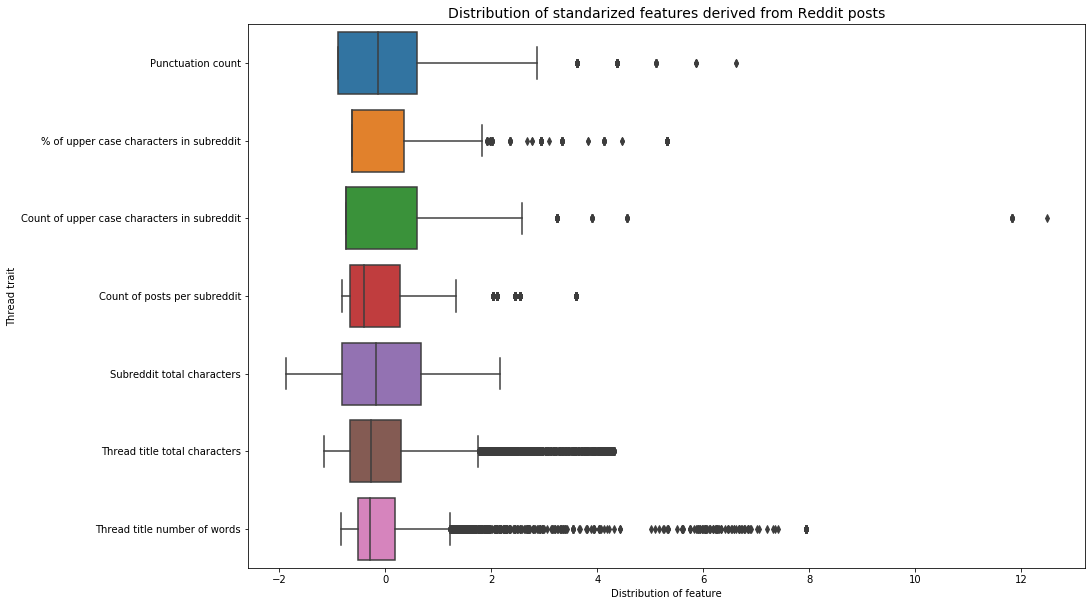

In [98]:
plt.figure(figsize=(15,10))
plt.title('Distribution of standarized features derived from Reddit posts', size=14)
plt.xlabel('Distribution of feature')
plt.ylabel('Thread trait')
plot = sns.boxplot(data=Xs.drop(columns=['num_comments','time_num','upper_count']),orient='h')
plot.set_yticklabels(['Punctuation count',
                      '% of upper case characters in subreddit',
                      'Count of upper case characters in subreddit',
                      'Count of posts per subreddit',
                      'Subreddit total characters',
                      'Thread title total characters',
                      'Thread title number of words',
                      '% of thread title upper case characters']);

Based on the distribution of the standarized features, it can be inferred that:
* Most posts have a punctuation count within around 1 standard deviation of the median with a few extreme high values
* There is less variation in the percentage of upper case characters in subreddit within close to a standard deviation from the median
* The percentage of upper case characters follows a similar distribution
* The count of posts per reddit has a median number of posts slightly below the mean, implying that some subreddits tend to post more frequently than others and may pull up the average value.
* The subreddit length has a relatively high spread based on the distance of the 25th,50th, and 75th percentiles in the box plot. Its median is also slightly below the mean.
* The number of total characters and words have a larger spread compared to other features such as title polarity. These features both have some high extreme values, signaling that certain posts may contain many words and characters.
* Most posts appear to have a polarity value around the mean, although some have very high and low polarity values, signaling that most values in this feature are closer to -1 and 1 instead of within the range of both.
* There is a larger spread within the title subjectivity feature compared to the title polarity.
* For the thread title with upper case characters, there is not much spread around the median but several posts with high extreme values, suggesting that including many upper case characters is not a frequent practice among redditors.

In [99]:
Xs.drop(columns=['num_comments','time_num','upper_count']).describe().T

,count,mean,std,min,25%,50%,75%,max
punc_count,10106.0,7.434353e-15,1.000049,-0.898394,-0.898394,-0.146807,0.604780,6.617478
sub_upper_case_pct,10106.0,-3.710931e-15,1.000049,-0.631903,-0.631903,-0.631903,0.359493,5.316473
sub_upper_count,10106.0,-1.184509e-15,1.000049,-0.735106,-0.735106,-0.735106,0.587248,12.488436
subreddit_cnt,10106.0,-2.964897e-15,1.000049,-0.826417,-0.677096,-0.399784,0.282829,3.589237
subreddit_len,10106.0,9.881930e-16,1.000049,-1.872111,-0.811467,-0.175081,0.673434,2.158335
title_len,10106.0,-9.014383e-17,1.000049,-1.151073,-0.671002,-0.273229,0.293711,4.317160
upper_case_pct,10106.0,-2.496313e-17,1.000049,-0.840323,-0.524204,-0.285433,0.171867,7.931988


#### Examine the distribution of the remaining numerical features

#### Explore the distribution of the number of hours a post has been up on Reddit.
The distribution of the number of hours the post was up on reddit appears to be normally distributed for 100 or less hours since posting. Explore the posts with more than 100 hours (4 days) since posting.

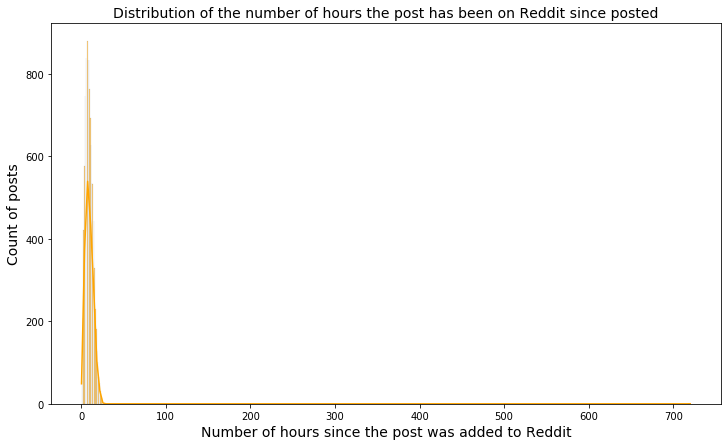

In [100]:
plt.figure(figsize=(12,7))
plt.xlabel('Number of hours since the post was added to Reddit',size=14)
plt.ylabel('Count of posts',size=14)
plt.title('Distribution of the number of hours the post has been on Reddit since posted',size=14)
sns.histplot(data=df,x='time_num', kde=True, color='orange');

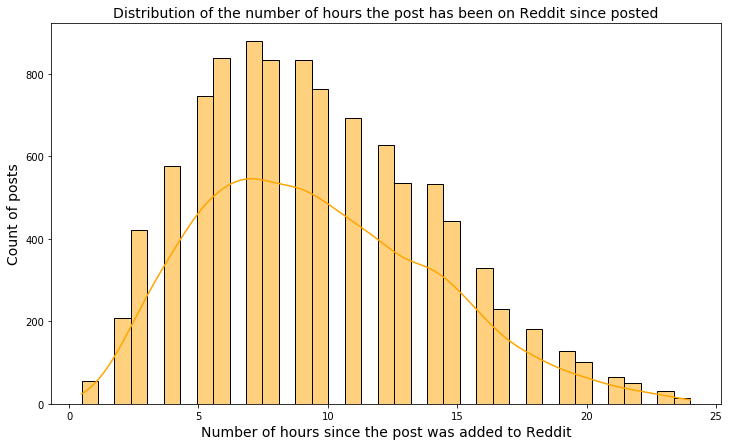

In [101]:
plt.figure(figsize=(12,7))
plt.xlabel('Number of hours since the post was added to Reddit',size=14)
plt.ylabel('Count of posts',size=14)
plt.title('Distribution of the number of hours the post has been on Reddit since posted',size=14)
sns.histplot(data=df[df['time_num'] <100],x='time_num', kde=True, color='orange');

In [102]:
df[df['time_num']>100]

,title,subreddit,image,video,time_num,date_posting,hour of posting,num_comments,high_num_comments,question_in_title,...,hour_posted,title_len,punc_count,upper_count,upper_case_pct,subreddit_text,subreddit_len,sub_upper_count,sub_upper_case_pct,subreddit_cnt
9355,"Meanwhile at the SiriusXM house, Dave Grohl is...",u/SiriusXMRadio,0.0,1.0,720.0,2021-11-23,9,19.0,0,0,...,0,131,3,13,9.923664,SiriusXMRadio,13,4,30.769231,1


Only one post had been posted for more than 100 hours, which had been posted for a month. Given that this is only one observation, it will be dropped from the data set to allow the model to fit the data better.

In [103]:
df = df[df['time_num']<100]

In [104]:
df.reset_index(drop=True,inplace=True)

#### Explore the relationships between the features in the data set and whether a post is classified as having a median number of posts that is above the median

From the pairplots below, it can be inferred that:
* Overall, posts with a higher number of punctuation signs appear to have a lower number of comments
* A higher number of comments is associated with lower percentages of upper case characters in the subreddit
* There does not appear to be a clear relationship between the number of posts by subreddit and the number of commnents
* The same is applicable betwween the subreddit length and the number of comments
* As expected, on average, there appears to be a positive relationship between the amount of time a post has been up on reddit and the number of comments.
* Title lengths that are 100 characters or shorter in length appear to be associated with a higher number of comments and belong to the classification of a high number of comments.
* A lower percentage of upper case letters in the thread title appears to be associated with a higher number of comments and the high number of comments classification

The following resources were useful in producing these visualizations ([1](https://www.statology.org/seaborn-legend-position/) + [2](https://pretagteam.com/question/how-to-edit-a-seaborn-legend-title-and-labels-for-figurelevel-functions) + [3](https://stackoverflow.com/questions/37815774/seaborn-pairplot-legend-how-to-control-position))

In [105]:
def pairplot(x_vars,x_labels):
    plt.figure(figsize=(30,7))
    plot = sns.pairplot(data=df,x_vars=x_vars, y_vars='num_comments', hue='high_num_comments')
    plot.fig.suptitle("Relationship between key features and number of comments", y=1.09)
    plot._legend.remove()
    plt.legend(title='# comments > median', bbox_to_anchor=(1.2, 1.2), loc = 'upper right',borderaxespad=0)
    plot.axes[0,0].set_ylabel('Number of comments')
    plot.axes[0,0].set_xlabel(x_labels[0])
    plot.axes[0,1].set_xlabel(x_labels[1])
    plot.axes[0,2].set_xlabel(x_labels[2])
    plot.axes[0,3].set_xlabel(x_labels[3])
    plot._legend.set_title('# comments above median');
    return

<Figure size 2160x504 with 0 Axes>

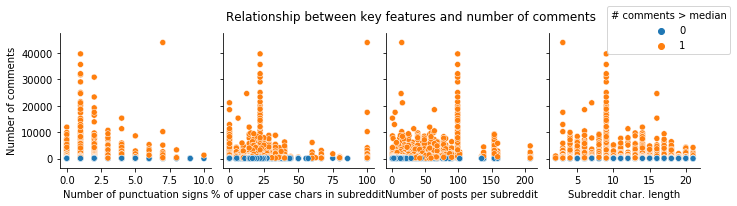

In [106]:
pairplot(['punc_count','sub_upper_case_pct','subreddit_cnt','subreddit_len'],
         ['Number of punctuation signs','% of upper case chars in subreddit',
         'Number of posts per subreddit','Subreddit char. length'])

<Figure size 2160x504 with 0 Axes>

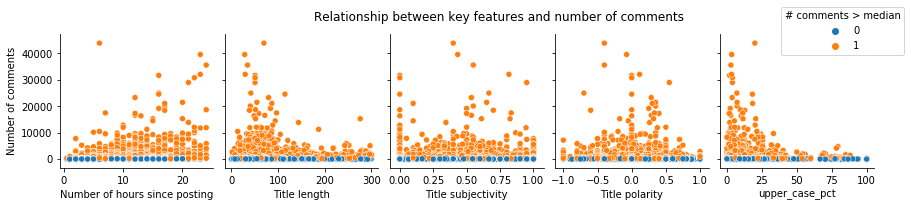

In [107]:
pairplot(['time_num','title_len','title_subjectivity','title_polarity','upper_case_pct'],
        ['Number of hours since posting','Title length','Title subjectivity','Title polarity',
         '% upper case chars in title']);

#### Plot the average number of comments against the binary explanatory variables in the data set.
It appears that there are significant variations in the number of comments when the data are disaggregated by these features.

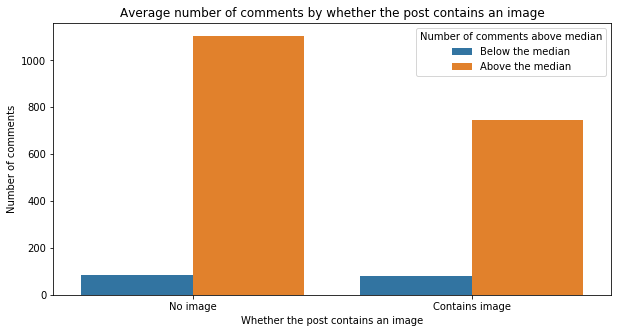

In [108]:
plt.figure(figsize=(10,5))
plot = sns.barplot(data=df,x='image', y='num_comments',ci= None, hue='high_num_comments')
plt.ylabel('Number of comments')
plt.xlabel('Whether the post contains an image')
plot.set_xticklabels(['No image','Contains image'])
plt.title('Average number of comments by whether the post contains an image')
plot.legend(title='Number of comments above median', loc='upper right', labels=['Below the median','Above the median']);

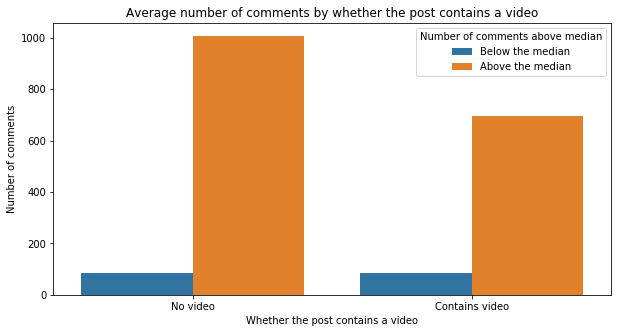

In [109]:
plt.figure(figsize=(10,5))
plot = sns.barplot(data=df,x='video', y='num_comments',ci= None, hue='high_num_comments')
plt.ylabel('Number of comments')
plt.xlabel('Whether the post contains a video')
plot.set_xticklabels(['No video','Contains video'])
plt.title('Average number of comments by whether the post contains a video')
plot.legend(title='Number of comments above median', loc='upper right',labels=['Below the median','Above the median']);

In [110]:
df.reset_index(drop=True,inplace=True)

Based on this analysis the following features will not be used in this analysis as predictors:
* People and events indicator as it may be too narrow for titles from December, 2021
* Whether the post contains a dollar sign and the word versus due to the small number of posts that contain these characters
* Number of emojis as there does not appear to be a clear relationship between this feature and the number of comments
* Other features that will be kept in the data set as percentage values and not whole numbers

The remaining features appear to have at a minimum a moderate to low relationship with the number of comments. Therefore, the analysis will now include these features in addition to any additional features derived from the `TFIDF` vectorizer.

In [111]:
df.drop(columns=['subreddit','date_posting','hour of posting','dollar_sign',
                'num_emojis','upper_count','subreddit_text','sub_upper_count'],inplace=True)

#### Run a preliminary KNN model using the features available and derived to identify their predictive power

In [112]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [113]:
X = df.drop(columns=['title','num_comments','high_num_comments'])
y = df['high_num_comments']

In [114]:
Xs = ss.fit_transform(X)

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=5)
lr = LogisticRegression()

These features improve the performance of the model over the null model based on the accuracy score above using a KNN and logistic regression models. Therefore, these features can be will be used to answer the initial problem statement. The accuracy will be improved by using a natural language processing model and additional classification models.

In [116]:
round(cross_val_score(knn,Xs,y,cv=5).mean(),2),'+/-',2 * round(cross_val_score(knn,Xs,y,cv=5).std(),2) 

(0.61, '+/-', 0.06)

In [117]:
round(cross_val_score(lr,Xs,y,cv=5).mean(),2),'+/-',2 * round(cross_val_score(lr,Xs,y,cv=5).std(),2) 

(0.62, '+/-', 0.12)

In [118]:
lr.fit(Xs,y)

LogisticRegression()

In [119]:
np.exp(lr.coef_)

array([[0.80699181, 0.881976  , 2.24885449, 1.27379827, 1.06174267,
        0.95211558, 1.07232651, 1.19006402, 1.06679282, 1.12347913,
        0.88753864, 1.01336483, 1.03960196, 1.04074336, 1.17417562]])

In [120]:
coeffs = pd.DataFrame(zip(X.columns,lr.coef_.reshape(-1,1)), columns=['Feature', 'Reg Coefficient'])
coeffs['Reg Coefficient'] = coeffs['Reg Coefficient'].astype(float)
coeffs = coeffs.sort_values(by='Reg Coefficient', ascending=False)
coeffs = coeffs.drop(index=0)
feature_names = list(coeffs['Feature'].values)

In [121]:
coeffs

,Feature,Reg Coefficient
2,time_num,0.810421
3,question_in_title,0.242003
7,holiday,0.174007
14,subreddit_cnt,0.160566
9,title_len,0.116430
6,title_subjectivity,0.069831
8,hour_posted,0.064657
4,competition_key_word,0.059912
13,sub_upper_case_pct,0.039935
12,subreddit_len,0.038838


Even though these features improve the accuracy of the model, they do not necessariy increasing the odds of a post having a higher number of comments above the median. However, certain features have a small association with higher odds of having a number of comments above the median such as:
* The amount of time the post has been up on reddit
* Whether a post is framed in the form of a question
* Whether the post was added during a holiday
* The frequency of posts associated with the subreddit
* The thread length

Some features of threads are associated with lower odds of having a number of comments above the median, including:
* Including a video
* Including a higher number of punctuation signs
* Higher polarity
* A higher number of upper case letters

This suggests that posts, on average, should be framed in a way that draws attention in the form of a question and not necessarily including strong opinions, videos, and too many upper case letters.

This analysis is improved next through a natural language processing model.

### Export a file to be used for the analysis

In [122]:
df.to_csv('./data/cleaned-data-for-analysis.csv',index=False)